In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

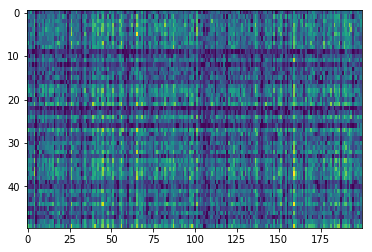

In [2]:
m, n, rank = 50, 200, 3

W_true = npr.rand(m, rank)
H_true = npr.rand(rank, n)

data = np.dot(W_true, H_true)
data += npr.randn(m, n) * .2
data = np.maximum(0, data)

plt.imshow(data, aspect='auto', interpolation='none')

In [3]:
from lvl.factor_models import NMF
model = NMF(n_components=1)
model.fit(data)

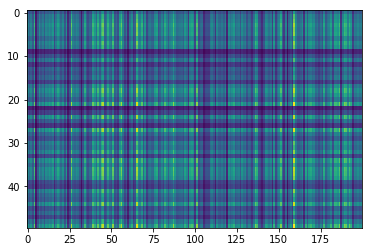

In [4]:
W, H = model.factors
est = np.dot(W, H)
plt.imshow(est, aspect='auto', interpolation='none')

In [5]:
from tqdm import tqdm
from lvl.crossval import bicv_scores, speckled_cv_scores

n_ranks = 5
ranks = np.arange(1, n_ranks + 1)
n_repeats = 40

nmf_train_scores = np.ones((n_ranks, n_repeats))
nmf_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = NMF(n_components=rank)
    nmf_train_scores[i], nmf_test_scores[i] = \
        bicv_scores(model, data, n_repeats=n_repeats)

100%|██████████| 5/5 [00:12<00:00,  2.69s/it]


In [6]:
from lvl.factor_models import TSVD

tsvd_train_scores = np.ones((n_ranks, n_repeats))
tsvd_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = TSVD(n_components=rank)
    tsvd_train_scores[i], tsvd_test_scores[i] = \
        speckled_cv_scores(model, data, n_repeats=n_repeats)    

100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


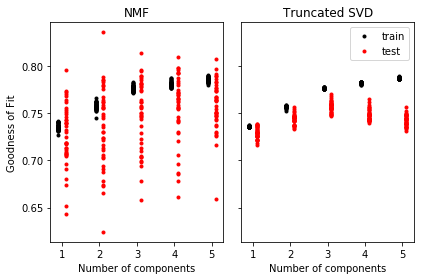

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True)

rax = np.tile(ranks, (n_repeats, 1)).T.ravel()

axes[0].plot(rax-.1, nmf_train_scores.ravel(), '.k');
axes[0].plot(rax+.1, nmf_test_scores.ravel(), '.r');
axes[0].set_title("NMF")

axes[1].plot(rax-.1, tsvd_train_scores.ravel(), '.k', label='train');
axes[1].plot(rax+.1, tsvd_test_scores.ravel(), '.r', label='test');
axes[1].set_title("Truncated SVD")
axes[1].legend()

axes[0].set_ylabel("Goodness of Fit")
for ax in axes:
    ax.set_xlabel("Number of components")
plt.tight_layout()

In [8]:
from lvl.crossval import bicv_scores

nmf_train_scores = np.ones((n_ranks, n_repeats))
nmf_test_scores = np.ones((n_ranks, n_repeats))

for i, rank in enumerate(tqdm(ranks)):
    model = NMF(n_components=rank)
    nmf_train_scores[i], nmf_test_scores[i] = \
        bicv_scores(model, data, n_repeats=n_repeats)

  0%|          | 0/5 [00:00<?, ?it/s]

> /Users/alex/code/lvl/lvl/crossval.py(109)bicv_scores()
    108         # Extend model factors.
--> 109         model.bicv_extend(B, C)
    110 

ipdb> W, H = model.factors
ipdb> W.shape
(45, 1)
ipdb> H.shape
(1, 180)
ipdb> model.bicv_extend(B, C)
ipdb> model.W
*** AttributeError: 'NMF' object has no attribute 'W'
ipdb> W2, H2 = model.factors
ipdb> p W
array([[0.59118885],
       [0.52810654],
       [0.716023  ],
       [0.4328271 ],
       [0.39917481],
       [0.24078199],
       [0.3331055 ],
       [0.42566182],
       [0.67695473],
       [0.44923097],
       [0.62386585],
       [0.43289259],
       [0.53948511],
       [0.4568528 ],
       [0.39102992],
       [0.58900833],
       [0.39673486],
       [0.46729168],
       [0.5410494 ],
       [0.50165962],
       [0.33856486],
       [0.57896309],
       [0.40158395],
       [0.34302512],
       [0.4306285 ],
       [0.48765694],
       [0.36102468],
       [0.22591139],
       [0.27182581],
       [0.38009159],
       [0.8220

BdbQuit: 

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True)

rax = np.tile(ranks, (n_repeats, 1)).T.ravel()

axes[0].plot(rax-.1, nmf_train_scores.ravel(), '.k');
axes[0].plot(rax+.1, nmf_test_scores.ravel(), '.r');
axes[0].set_title("NMF")

axes[1].plot(rax-.1, tsvd_train_scores.ravel(), '.k', label='train');
axes[1].plot(rax+.1, tsvd_test_scores.ravel(), '.r', label='test');
axes[1].set_title("Truncated SVD")
axes[1].legend()

axes[0].set_ylabel("Goodness of Fit")
for ax in axes:
    ax.set_xlabel("Number of components")
plt.tight_layout()